# Abstract
#### Setting

        1. 캐글의 House Prices - Advaced Regression Techniques 


#### Method
        
        1. 흔하게 사용하는 One-Hot-Encoding 외의 Smoothing 기법 활용
        2. 기존에 사용하던 평균 앙상블 외의 Model stacking 적용
        3. shap 라이브러리를 이용하여 Feature importance를 다양하게 출력

#### Result
        **LGBM**
        1. rmse : 0.13337 rmse : 27881.5164532458
        **RF**
        1. rmse :  32599.806800051516
        **RFregression**
        1. rmse : 32369.00146910789
        **XGBoost**
        1. rmse : 26497.32500764802
        **catBoost**
        1. rmse : 31123.49221255535

        Model stack : 

                            
                            

<div style="background-color:rgba(0, 255, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center style ="margin-left : 20px;">Plan</center></h1>
</div>

**After pre-processing and data analysis, I will create and stack several models to create an optimal model.**

(smoothing)**reference**  : https://www.kaggle.com/dustinthewind/making-sense-of-mean-encoding<br><br>
(stacking)**reference**  : https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda#notebook-container

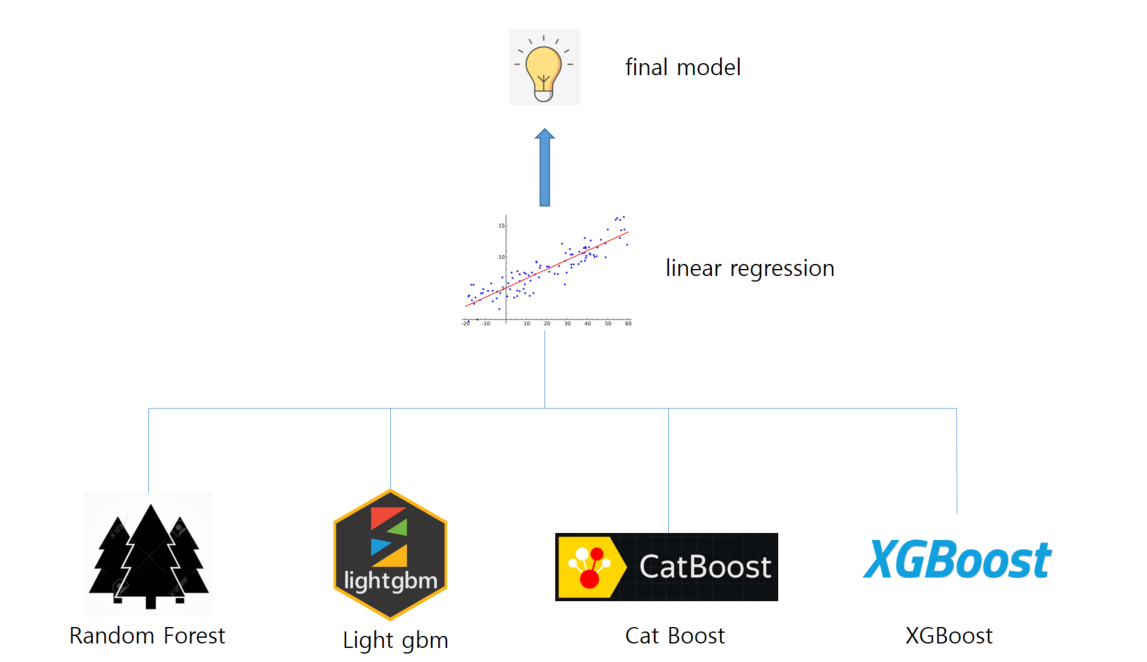

In [1]:
#IMPORT THE LIBRARIES....
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import shap

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/data_description.txt
../data/sample_submission.csv
../data/test.csv
../data/train.csv


<div style="background-color:rgba(0, 255, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center style ="margin-left : 20px;">import</center></h1>
</div>

In [5]:
# data Load
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

<h3>Check for null values

In [6]:
train.isnull().sum()[train.isnull().sum() != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

<h4>Remove features with more than half null values, exclude meaningless columns such as ID

In [7]:
# train data 'id' remove
train_df = train.drop(['Id', 'MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'Alley'], axis=1)
test_df = test.drop(['Id', 'MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'Alley'], axis=1)

<div style="background-color:rgba(0, 0, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center style ="margin-left : 20px;">Smoothing</center></h1>
</div>

In [8]:
def encode_target_smooth(data, target, categ_variables, smooth):
    """    
    Apply target encoding with smoothing.
    
    Parameters
    ----------
    data: pd.DataFrame
    target: str, dependent variable
    categ_variables: list of str, variables to encode
    smooth: int, number of observations to weigh global average with
    
    Returns
    --------
    encoded_dataset: pd.DataFrame
    code_map: dict, mapping to be used on validation/test datasets 
    defaul_map: dict, mapping to replace previously unseen values with
    """
    train_target = data.copy()
    code_map = dict()    # stores mapping between original and encoded values
    default_map = dict() # stores global average of each variable
    
    for v in categ_variables:
        prior = data[target].mean()
        n = data.groupby(v).size()
        mu = data.groupby(v)[target].mean()
        mu_smoothed = (n * mu + smooth * prior) / (n + smooth)
        
        train_target.loc[:, v] = train_target[v].map(mu_smoothed)        
        code_map[v] = mu_smoothed
        default_map[v] = prior        
    return train_target, code_map, default_map

<h3>Extract only object type

In [9]:
Tr_mean = pd.concat([train_df.loc[:, train_df.dtypes == object],train_df['SalePrice']], axis =1)
Te_mean = test_df.loc[:, test_df.dtypes== object]

In [10]:
cat_vars = ['MSZoning', 'Street', 'LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
            'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish',
            'GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition']

train_target_smooth, target_map, default_map = encode_target_smooth(Tr_mean , 'SalePrice', cat_vars, 500)
test_target_smooth = Te_mean.copy()
for v in cat_vars:
    test_target_smooth.loc[:, v] = test_target_smooth[v].map(target_map[v])

<h3>Apply smoothing

In [11]:
no_Tr_mean = train_df.loc[:, train_df.dtypes != object]  ##object아닌 train features
no_Tr_mean = no_Tr_mean.drop(['SalePrice'],axis =1)
no_Te_mean = test_df.loc[:, train_df.dtypes != object]   ##object아닌 test features

df_train = pd.concat([train_target_smooth,no_Tr_mean], axis = 1)
df_test = pd.concat([test_target_smooth,no_Te_mean], axis = 1)

<h4>Null value averaging

In [12]:
df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_test.mean())

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>lightGBM Modeling</center></h1>
</div>

In [13]:
# data segmentation
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0) # train, valid 8:2 분할

<h3>Find the optimal parameters

In [14]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('Optimal mean RMSE value:', np.round(rmse, 4))
    print('Optimal parameters:', grid_model.best_params_)
    
    return grid_model.best_estimator_

In [15]:
lgbm_params = {'n_estimators':[3300]}

lgbm_reg = LGBMRegressor(n_estimators=3300, bagging_fraction=0.7, learning_rate=0.1,
                         max_depth=4, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1)

best_lgbm = get_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fractio

In [16]:
best_lgbm

LGBMRegressor(bagging_fraction=0.7, colsample_bytree=0.5, feature_fraction=0.9,
              max_depth=4, n_estimators=3300, reg_lambda=5, subsample=0.7)

In [17]:
# lgbm 
lgbm_model = LGBMRegressor(bagging_fraction=0.7, colsample_bytree=0.5, feature_fraction=0.9,
              max_depth=4, n_estimators=3300, reg_lambda=5, subsample=0.7, random_state=0)

In [18]:
# model training
lgbm_model.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.7, colsample_bytree=0.5, feature_fraction=0.9,
              max_depth=4, n_estimators=3300, random_state=0, reg_lambda=5,
              subsample=0.7)

In [19]:
# RMSE function
def calculate_rmse(actual, prediction):
    sum = 0
    for a, p in zip(actual, prediction):
        sum += (a - p)**2
    mse = sum/len(actual)
    rmse = np.sqrt(mse)
    return rmse

In [20]:
# x_valid data predict
valid_prediction = lgbm_model.predict(X_valid)

In [21]:
# valid data rmse
calculate_rmse(y_valid, valid_prediction)

27881.5164532458

In [22]:
# test data predict
lgbm_prediction = lgbm_model.predict(df_test)

In [23]:
submission_lgbm = pd.DataFrame({'Id':test['Id'], 'SalePrice':lgbm_prediction})
submission_lgbm.head()

,Id,SalePrice
0,1461,119504.136753
1,1462,155487.202859
2,1463,191959.297055
3,1464,191147.297422
4,1465,176232.454981


<h3>Features Variable Importance

In [24]:
explainer = shap.TreeExplainer(lgbm_model) # Tree model Shap Value 
shap_values = explainer.shap_values(X_valid) # Shap Values 

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_valid.iloc[1,:])

In [26]:
shap.force_plot(explainer.expected_value, shap_values, X_valid)

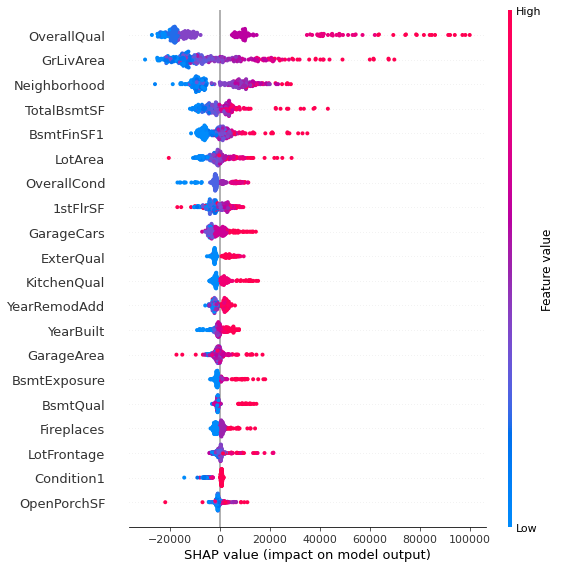

In [24]:
shap.summary_plot(shap_values, X_valid)

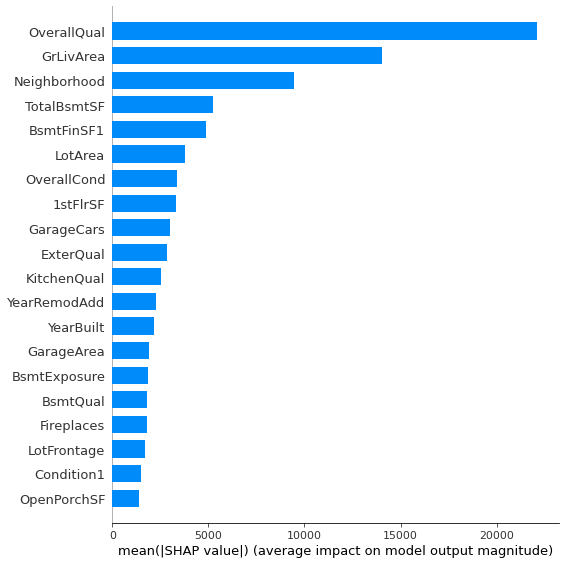

In [25]:
shap.summary_plot(shap_values, X_valid, plot_type = "bar")

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>RFregression Modeling</center></h1>
</div>

In [27]:
# data segmentation
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0) # train, valid 8:2 분할

In [28]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

mseOos = []
nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    maxFeat = 4 #try diff value
    wineRFModel = ensemble.RandomForestRegressor(n_estimators=iTrees,
                    max_depth=depth, max_features=maxFeat,
                    oob_score=False, random_state=531)
    wineRFModel.fit(X_train, y_train)
    #데이터 세트에 대한 MSE 누적
    prediction = wineRFModel.predict(X_train)
    mseOos.append(mean_squared_error(y_train, prediction))
print("MSE")
print(mseOos)

MSE
[130139365.66040309, 125554062.32083689, 124412264.12775439, 121638252.69916365, 118233569.04423748, 118327117.45737964, 113906215.71070126, 113920172.77097203, 113555667.89253205, 114079568.58895288, 114438066.6141089, 112794481.43913426, 111642241.67486149, 112184254.57208714, 113087880.08819553, 113602804.7131685, 113762059.54201335, 113100000.76678775, 112691645.96637799, 113091041.4431197, 113682356.5382489, 113747629.04875754, 112896904.82654703, 113100655.62062375, 114967092.07176122, 114207025.16214542, 113940989.64974558, 114388598.4522164, 114653156.17584883, 114595139.56190348, 113598481.7539276, 114668106.23554733, 114097891.03746875, 113999733.83025777, 114370882.25335374, 114512260.06978782, 114468650.48774461, 115041855.03079285, 114210294.62910162, 113994887.16958769, 113966938.84254433, 113791898.85526396, 114114434.1220536, 114467724.39712907, 114467559.16687019]


In [29]:
regr = RandomForestRegressor(max_depth=1000, random_state=1000,
                          n_estimators=150)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=1000, n_estimators=150, random_state=1000)

In [30]:
# RMSE function
def calculate_rmse(actual, prediction):
    sum = 0
    for a, p in zip(actual, prediction):
        sum += (a - p)**2
    mse = sum/len(actual)
    rmse = np.sqrt(mse)
    return rmse

In [30]:
valid_prediction = regr.predict(X_valid)

In [31]:
calculate_rmse(y_valid, valid_prediction)

32369.00146910789

In [31]:
RFR_prediction = regr.predict(df_test)

In [32]:
submission_RFR = pd.DataFrame({'Id':test['Id'], 'SalePrice':RFR_prediction})
submission_RFR.head()

,Id,SalePrice
0,1461,127751.440000
1,1462,155284.000000
2,1463,187556.286667
3,1464,187469.933333
4,1465,197465.300000


<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>RFclassifier Modeling</center></h1>
</div>

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수

# sample 1000, tree depth - 1000(max)
RF = RandomForestClassifier(n_estimators=1000, max_depth=1000,random_state=0)
RF.fit(X_train,y_train)

RandomForestClassifier(max_depth=1000, n_estimators=1000, random_state=0)

In [35]:
# RMSE function
def calculate_rmse(actual, prediction):
    sum = 0
    for a, p in zip(actual, prediction):
        sum += (a - p)**2
    mse = sum/len(actual)
    rmse = np.sqrt(mse)
    return rmse

In [36]:
valid_prediction = RF.predict(X_valid)

In [37]:
calculate_rmse(y_valid, valid_prediction)

32599.806800051516

In [38]:
RF_prediction = RF.predict(df_test)

In [39]:
submission_RF = pd.DataFrame({'Id':test['Id'], 'SalePrice':RF_prediction})
submission_RF.head()

,Id,SalePrice
0,1461,129900
1,1462,151500
2,1463,192000
3,1464,181000
4,1465,180000


<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>XGBoost Modeling</center></h1>
</div>

In [40]:
# data segmentation
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0) # train, valid 8:2 분할

In [41]:
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

xgb_model = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.9,colsample_bylevel=0.8, max_depth=20)

xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

<h3>feture importance</h3>
(just see the code)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

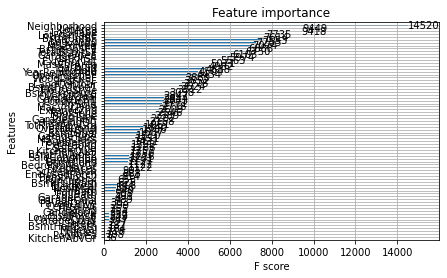

In [42]:
xgboost.plot_importance(xgb_model)

In [43]:
valid_prediction = xgb_model.predict(X_valid)

In [44]:
calculate_rmse(y_valid, valid_prediction)

25955.944916457203

In [45]:
xgb_model_prediction = xgb_model.predict(df_test)

In [46]:
# submission
submission_XGBoost = pd.DataFrame({'Id':test['Id'], 'SalePrice':xgb_model_prediction})
submission_XGBoost.head()

,Id,SalePrice
0,1461,126289.390625
1,1462,151503.984375
2,1463,188115.546875
3,1464,191023.203125
4,1465,184285.109375


<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>CatBoost Modeling</center></h1>
</div>

In [47]:
# data segmentation
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0) # train, valid 8:2 분할

In [48]:
from catboost import CatBoostRegressor
from catboost import Pool

In [49]:
catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid)
)

Learning rate set to 0.079637
0:	learn: 74737.5548101	test: 79371.7292681	best: 79371.7292681 (0)	total: 50.2ms	remaining: 25s
50:	learn: 24050.5341765	test: 33332.8527863	best: 33332.8527863 (50)	total: 151ms	remaining: 1.33s
100:	learn: 18970.7954529	test: 31201.2937677	best: 31123.4922126 (98)	total: 252ms	remaining: 994ms
Stopped by overfitting detector  (25 iterations wait)

bestTest = 31123.49221
bestIteration = 98

Shrink model to first 99 iterations.


In [50]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


<h3>Features Importance

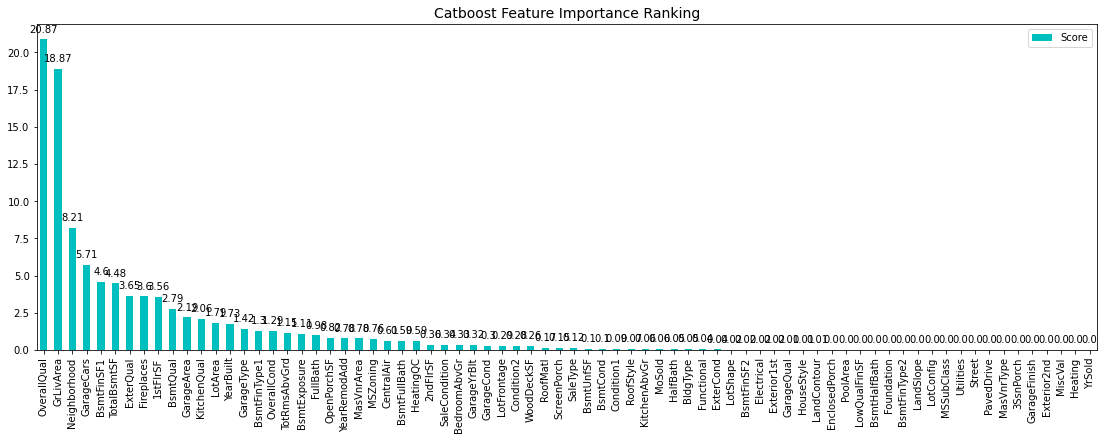

In [51]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=y_train)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [52]:
valid_prediction = catboost_model.predict(X_valid)
calculate_rmse(y_valid, valid_prediction)

31123.49221255535

In [53]:
catboost_model_prediction = catboost_model.predict(df_test)

In [54]:
# submission
submission_catboost = pd.DataFrame({'Id':test['Id'], 'SalePrice':catboost_model_prediction})
submission_catboost.head()

,Id,SalePrice
0,1461,126704.739175
1,1462,154998.875441
2,1463,177143.903077
3,1464,183681.983160
4,1465,209021.930720


<div style="background-color:rgba(255,255, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Model Stacking</center></h1>
</div>

<h3> I tried various things, but the best performance was achieved by stacking two XGboost and LightGMB.

In [55]:
# Dataset that will be the train set of the ensemble model.
# 
first_level = pd.DataFrame(catboost_model.predict(X_train), columns=['catboost'])
first_level['xgbm'] = xgb_model.predict(X_train)
#first_level['random_forest'] = RF.predict(X_train)    
#first_level['RF_regression'] = regr.predict(X_train)
first_level['lgbm'] = lgbm_model.predict(X_train)
first_level['label'] = y_train.values
first_level.head(20)

,catboost,xgbm,lgbm,label
0,342851.036867,314812.843750,314741.258691,314813
1,98937.071031,109499.984375,109398.707113,109500
2,149028.022748,163499.953125,163274.883703,163500
3,265422.521860,271000.062500,271391.452774,271000
4,231504.871841,205000.062500,205202.042183,205000
5,190980.470416,185000.000000,185238.354515,185000
6,144903.469371,159999.937500,159693.459252,160000
7,176646.622036,154999.937500,154886.119656,155000
8,111710.218767,91000.007812,90916.948198,91000
9,122813.238315,131000.000000,130896.026541,131000


In [56]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_model.predict(df_test), columns=['catboost'])
first_level_test['xgbm'] = xgb_model.predict(df_test)
#first_level_test['random_forest'] = RF.predict(df_test)
#first_level_test['RF_regression'] = regr.predict(df_test)
first_level_test['lgbm'] = lgbm_model.predict(df_test)
first_level_test.head()

,catboost,xgbm,lgbm
0,126704.739175,126289.390625,119504.136753
1,154998.875441,151503.984375,155487.202859
2,177143.903077,188115.546875,191959.297055
3,183681.983160,191023.203125,191147.297422
4,209021.930720,184285.109375,176232.454981


**meta_model**

In [57]:
RF_meta_model = RandomForestClassifier(n_estimators=1000, max_depth=1000,random_state=0)

In [58]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
RF_meta_model.fit(first_level, y_train)

RandomForestClassifier(max_depth=1000, n_estimators=1000, random_state=0)

In [59]:
ensemble_pred = RF_meta_model.predict(first_level)
final_predictions = RF_meta_model.predict(first_level_test)

# Submission

In [60]:
submission_meta_model = pd.DataFrame({'Id':test['Id'], 'SalePrice':final_predictions})
submission_meta_model.head()

,Id,SalePrice
0,1461,120000
1,1462,155000
2,1463,189950
3,1464,191000
4,1465,178000


In [61]:
submission_meta_model.to_csv('./submission.csv', index=False)

<div style="background-color:rgba(0,255, 2, 0.5);border-radius:5px;display:fill">
    <h1><center>Log</center></h1>
</div>